In [ ]:
# Пока недоделано. Прошу повременить с проверкой! :)

# Реализация логистической регрессии в TensorFlow

In [3]:
import numpy as np
import tensorflow as tf

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

## Генерируем данные для задачи регрессии

In [5]:
NUM_FEATURES = 2
NUM_SAMPLES = 1000

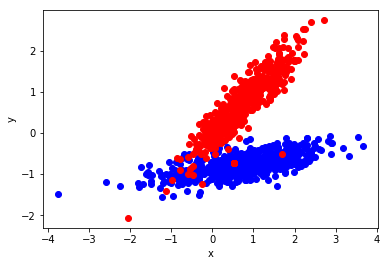

In [6]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = NUM_SAMPLES,
                           n_features = NUM_FEATURES,
                           n_informative = NUM_FEATURES,
                           n_redundant = 0,
                           n_classes = 2,
                           n_clusters_per_class = 1,
                           class_sep = 0.75,
                           random_state = 54312)

y = y.reshape(-1, 1)

ones = np.where(y == 1)   # индексы объектов класса '1'
zeros = np.where(y == 0)  # индексы объектов класса '0'

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or');

## Вспомогательная функция для создания операций

In [7]:
import string

def py_func_with_grad(func, inp, Tout, grad, name = None, stateful = False, graph = None):
    
    name_prefix = ''.join(np.random.choice(list(string.ascii_letters), size = 10))
    
    name = '%s_%s' % (name_prefix, name or '')
    grad_func_name = '%s_grad' % name

    tf.RegisterGradient(grad_func_name)(grad)

    g = graph or tf.get_default_graph()
    with g.gradient_override_map({'PyFunc': grad_func_name, 
                                  'PyFuncStateless': grad_func_name}):
        with tf.name_scope(name, 'PyFuncOp', inp):
            return tf.py_func(func, inp, Tout, stateful = stateful, name = name)

## Реализация линейной опреаций

In [102]:
def linear_op_forward(X, W):
    ''' Реализация линейной операции '''
    return np.dot(X, W.T) # аргументы являются numpy-массивами

def linear_op_backward(op, grads):
    ''' Реализация вычисления градиента линейной операции '''
    X = op.inputs[0]  # тензор входных данных
    W = op.inputs[1]  # тензор параметров модели
    dX = tf.multiply(grads, W)
    dW = tf.reduce_sum(tf.multiply(X, grads),
                       axis = 0,
                       keep_dims = True)
    return dX, dW

def sigmoid_op_forward(X):
    # TODO: реализовать операцию sigmoid
    return 1/(1+np.exp(-X))

def sigmoid_op_backward(op, grads):
    #print('op', op.inputs[0] , 'grad',grads)
    y_pred = op.inputs[0]  # тензор входных данных
       
    g = tf.multiply(tf.sigmoid(y_pred),tf.subtract(tf.constant(1.0),tf.sigmoid(y_pred)))
    
    d = tf.multiply(grads, g)
    
    # TODO: реализовать вычисление градиента для sigmoid
    return d

In [21]:
def linear_op_forward(X, W, b):
    ''' Реализация линейной операции '''
    return np.dot(X, W.T) + b  # аргументы являются numpy-массивами

def linear_op_backward(op, grads):
    ''' Реализация вычисления градиента линейной операции '''
    X = op.inputs[0]  # тензор входных данных
    W = op.inputs[1]  # тензор параметров модели
    dX = tf.multiply(grads, W)
    dW = tf.reduce_sum(tf.multiply(X, grads),
                       axis = 0,
                       keep_dims = True)
    db = tf.reduce_sum(grads)
    return dX, dW, db

def sigmoid_op_forward(X):
    # TODO: реализовать операцию sigmoid
    return 1/(1+np.exp(-X))

def sigmoid_op_backward(op, grads):
    #print('op', op.inputs[0] , 'grad',grads)
    y_pred = op.inputs[0]  # тензор входных данных
       
    g = tf.multiply(tf.sigmoid(y_pred),tf.subtract(tf.constant(1.0),tf.sigmoid(y_pred)))
    
    d = tf.multiply(grads, g)
    
    # TODO: реализовать вычисление градиента для sigmoid
    return d

## Создание графа вычислений и обучение модели

In [ ]:
BATCH_SIZE = NUM_SAMPLES // 10

weights = None  # в этой переменной мы сохраним результат обучения модели
b = None
learning_curve = []  # значения ошибки на каждой итерации обучения

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES])
    plh_labels = tf.placeholder(dtype = tf.float32, shape = [None, 1])
    
    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(shape = [1, NUM_FEATURES],
                                          dtype = tf.float32,
                                          seed = 54321))
    var_b = tf.Variable(0.5, name='var_b')
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(linear_op_forward,         # функция предсказания модели 
                                 [plh_X, var_W, var_b],     # аргументы функции
                                 [tf.float32],              # тип выходных значений
                                 name = 'linear_op',        # имя операции 
                                 grad = linear_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)        # объект графа вчислений
    
    # создаем переменную для результата операции sigmoid
    var_Sigmoid = py_func_with_grad(sigmoid_op_forward,
                                    [var_Pred],
                                    [tf.float32],
                                    name = 'sigmoid_op',
                                    grad = sigmoid_op_backward,
                                    graph = sess.graph)
    
    # кроссэнтропийная функция потерь для бмнарной классификации
    cost = tf.losses.sigmoid_cross_entropy(plh_labels, var_Sigmoid)
    
    # инициализируем оптимизатор и указываем скорость обучения
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(cost)

    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    indices = np.arange(len(X))  # массив индексов объектов
    
    # выполняем итерации по 10-ти эпохам
    for _ in range(10):
        for epoch in range(10):
        
            # вначале каждой эпохи перемешиваем индексы
            np.random.shuffle(indices)
        
            # внутри каждой эпохи данные разбиваются на батчи
            for batch in range(len(X) // BATCH_SIZE):
            
                # выбираем индексы очередного батча
                batch_indices = indices[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]

                # выполняем шаг обучения: вычисляем ошибку и обновляем веса
                loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                                   feed_dict = {plh_X: X[batch_indices],  # передаем входные данные для вычисления
                                                plh_labels: y[batch_indices]})
        
                # сохраняем занчения ошибки для построения кривой обучения
                learning_curve.append(loss)
            
                # выводим текущее значение ошибки для каждого 10го шага
                steps = len(learning_curve) - 1
                if steps % 10 == 0:
                    print('[%03d] loss=%.3f weights=%s b=%s' % (steps, loss, var_W.eval(), var_b.eval()))
    
        # сохраняем обученные веса
        weights = var_W.eval()
        b = var_b.eval()

[000] loss=0.736 weights=[[0.420605   0.22537181]] b=0.49129626
[010] loss=0.664 weights=[[ 0.2908698  -0.16117379]] b=0.32933635
[020] loss=0.678 weights=[[ 0.13166666 -0.5857225 ]] b=0.12124256
[030] loss=0.645 weights=[[ 0.04808936 -0.941438  ]] b=-0.03443412
[040] loss=0.637 weights=[[ 0.03236563 -1.223261  ]] b=-0.14638124
[050] loss=0.606 weights=[[ 0.04680688 -1.4650238 ]] b=-0.22351371
[060] loss=0.605 weights=[[ 0.07406751 -1.670356  ]] b=-0.29486763
[070] loss=0.630 weights=[[ 0.10950209 -1.8527333 ]] b=-0.35915765
[080] loss=0.614 weights=[[ 0.15696865 -2.014777  ]] b=-0.40964442
[090] loss=0.620 weights=[[ 0.2007108 -2.1607912]] b=-0.46104088
[100] loss=0.578 weights=[[ 0.24566476 -2.2986035 ]] b=-0.50155795
[110] loss=0.561 weights=[[ 0.28928939 -2.4215806 ]] b=-0.5512405
[120] loss=0.592 weights=[[ 0.32828575 -2.5356712 ]] b=-0.5975298
[130] loss=0.581 weights=[[ 0.368481 -2.642705]] b=-0.6434647
[140] loss=0.549 weights=[[ 0.40731797 -2.7440827 ]] b=-0.68199974
[150] los

## Визуализируем кривую обучения

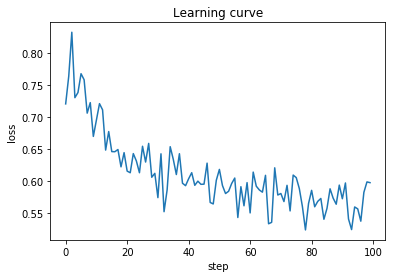

In [40]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve')
plt.plot(learning_curve);

## Визуализируем разделяющую гиперплоскость

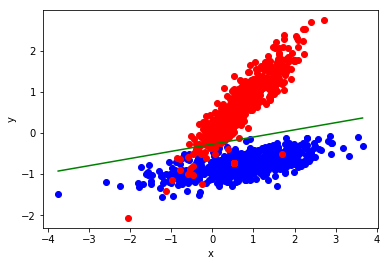

In [41]:
y_pred = - (X[:, 0] * weights[0, 0]+b) / weights[0, 1]

order = np.argsort(X[:, 0])

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or',
         X[order, 0], y_pred[order], '-g');